In this notebook, I model the volatilty of the S&P500 index using the GARCH(1,1) model.

In [86]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox

Download the S&P500 data from yfinance from 10 July 2015 to 9 July 2020.

In [87]:
data = yf.download("^GSPC", start="2015-07-10", end="2020-07-10", auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [88]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-07-10,2076.620117,2081.310059,2052.739990,2052.739990,3065070000
2015-07-13,2099.600098,2100.669922,2080.030029,2080.030029,3096730000
2015-07-14,2108.949951,2111.979980,2098.179932,2099.719971,3002120000
2015-07-15,2107.399902,2114.139893,2102.489990,2109.010010,3261810000
2015-07-16,2124.290039,2124.419922,2110.550049,2110.550049,3227080000


Find the daily returns in percentage

In [89]:
returns = 100*data["Close"].pct_change().dropna()
returns.head()

Ticker,^GSPC
Date,
2015-07-13,1.106605
2015-07-14,0.445316
2015-07-15,-0.073499
2015-07-16,0.801468
2015-07-17,0.110618


Mean value of the returns

In [90]:
returns.mean()

Ticker
^GSPC    0.040674
dtype: float64

In [91]:
returns.reset_index(drop=True, inplace=True)

In [92]:
returns.head()

Ticker,^GSPC
0,1.106605
1,0.445316
2,-0.073499
3,0.801468
4,0.110618


Plotting the cumulative returns

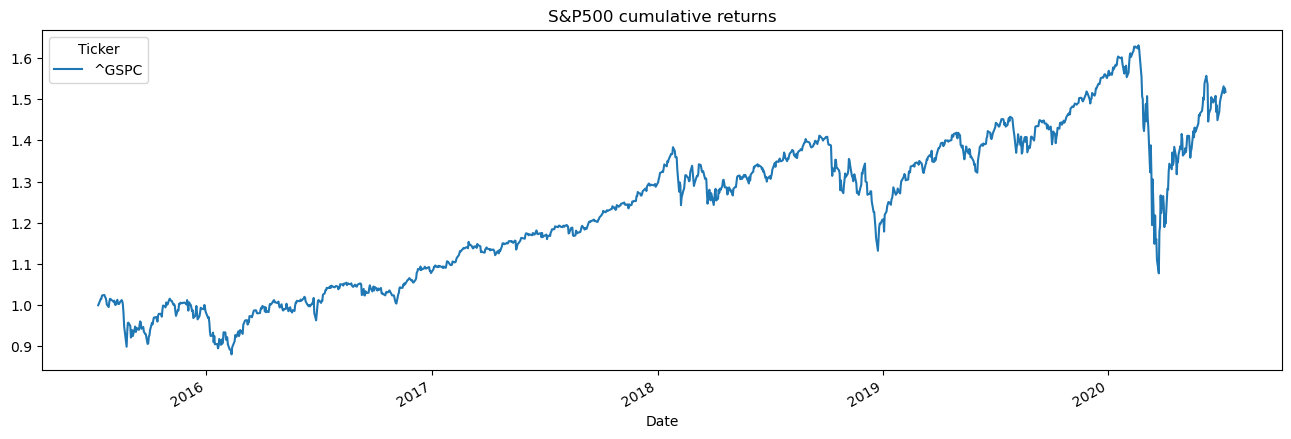

In [93]:
cumulative_returns = data["Close"] / data["Close"].iloc[0,:]
cumulative_returns.plot(figsize =(16,5), title = 'S&P500 cumulative returns');

Plotting the cumulative returns overlapped with 22-day rolling volatility 

In [94]:
cumulative_returns.reset_index(drop=True, inplace=True)
rolling_vol = abs(returns.rolling(window=50, min_periods=22).std().dropna())

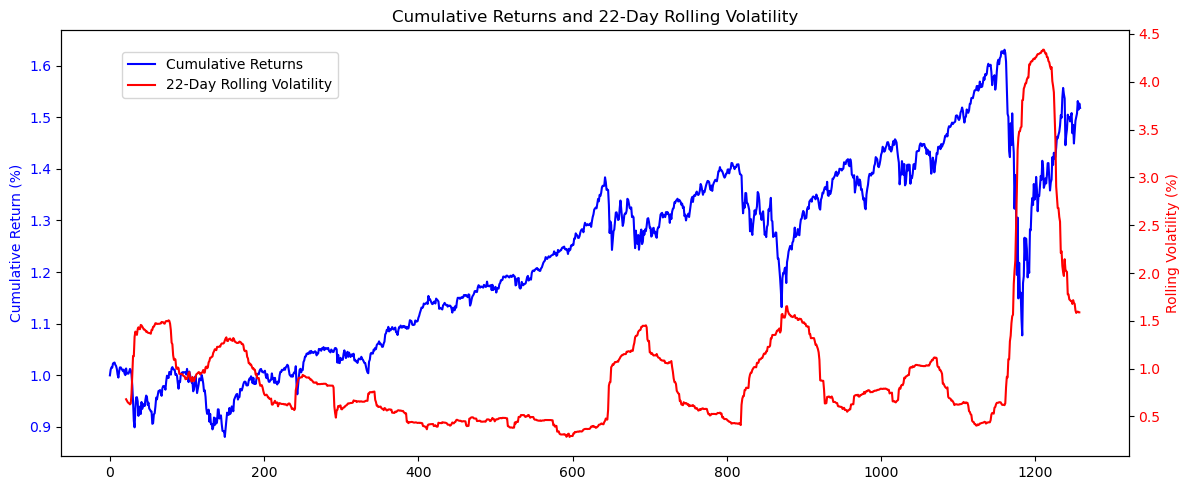

In [95]:
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(cumulative_returns.index, cumulative_returns, color='blue', label='Cumulative Returns')
ax1.set_ylabel('Cumulative Return (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(rolling_vol.index, rolling_vol, color='red', label='22-Day Rolling Volatility')
ax2.set_ylabel('Rolling Volatility (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Cumulative Returns and 22-Day Rolling Volatility')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

Daily, Monthly, and Annual volatilities

In [96]:
daily_volatility = returns.std().iloc[0]
monthly_volatility = math.sqrt(21) * daily_volatility
annual_volatility = math.sqrt(252) * daily_volatility

In [97]:
print("Daily volatility:", daily_volatility)
print("Monthly volatility:", monthly_volatility)
print("Annual volatility:", annual_volatility)

Daily volatility: 1.220805101491766
Monthly volatility: 5.5944317863742645
Annual volatility: 19.379680186957085


C:\Users\dande\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



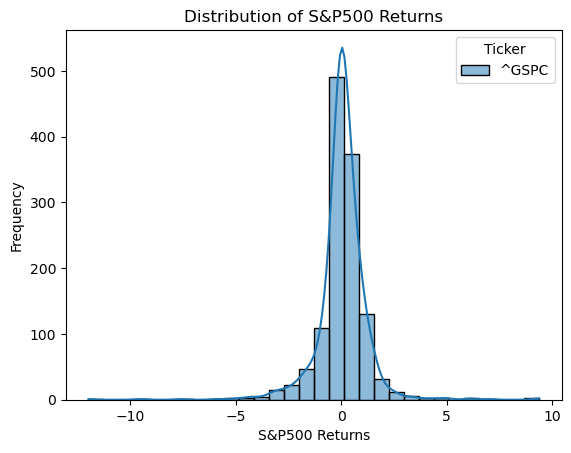

In [98]:
sns.histplot(returns, bins=30, kde=True);
plt.xlabel('S&P500 Returns')
plt.ylabel('Frequency')
plt.title('Distribution of S&P500 Returns')
plt.show()

Fit the GARCH(1,1) model to the volatility

In [99]:
model = arch_model(returns, mean = 'Zero', vol = 'GARCH', p=1, q=1)
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1526.41
Distribution:                  Normal   AIC:                           3058.83
Method:            Maximum Likelihood   BIC:                           3074.24
                                        No. Observations:                 1258
Date:                Mon, Jul 07 2025   Df Residuals:                     1258
Time:                        09:21:47   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0397  1.202e-02      3.307  9.434e-04 [1.619e-02,6.331e-02]
alpha[1]       0.2224  4.026e-02      5.525  3.291e-08     [  0.144,  0.301]
beta[1]        0.7484  3.414e-02     21.919 1.708e-106     [  0.681,  0.815]
============================================================================

Covariance estimator: robust
"""

Parameters of the model: $\omega=0.039628, ~\alpha=0.222406, ~\beta=0.748768$

In [100]:
parameters=model_fit.params
parameters

omega       0.039749
alpha[1]    0.222449
beta[1]     0.748371
Name: params, dtype: float64

Long term Variance ($V_L$) calulated from the model parameters. Corresponds to Long Term Volatility of 1.167%  

In [101]:
V_L=parameters.iloc[0]/(1-parameters.iloc[1]-parameters.iloc[2])
print(math.sqrt(V_L),"%")

1.1671279436977189 %


Ljung-Box Sttistic for GARCH(1,1) model

In [102]:
standardized_residuals = model_fit.std_resid.dropna()

print("\nLjung Box statistic on standardized residuals:")
ljung_mean = acorr_ljungbox(standardized_residuals, lags=[15], return_df=True)
print(ljung_mean)

print("\nLjung Box statistic on squared standardized residuals:")
ljung_var = acorr_ljungbox(standardized_residuals**2, lags=[15], return_df=True)
print(ljung_var)


Ljung Box statistic on standardized residuals:
    lb_stat  lb_pvalue
15  9.88799   0.826726

Ljung Box statistic on squared standardized residuals:
      lb_stat  lb_pvalue
15  12.709563    0.62472


Autocorrelations in the Squared Returns and in the Squared Standardized Residuals after GARCH(1,1) modelling. We see that the model has removed all the autocorrelations in the data.

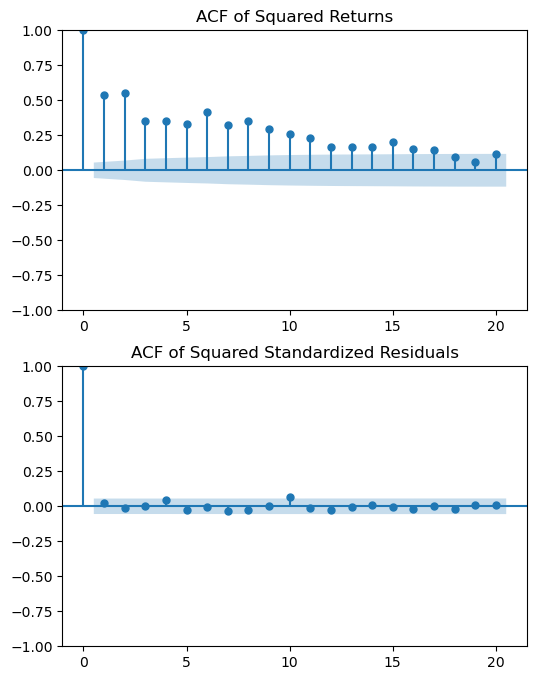

In [103]:
fig, axs = plt.subplots(2, figsize=(6, 8))
plot_acf(returns**2, lags=20, ax=axs[0])
axs[0].set_title("ACF of Squared Returns")
plot_acf(standardized_residuals**2, lags=20, ax=axs[1])
axs[1].set_title("ACF of Squared Standardized Residuals")
plt.show()

Forecasting volatility on a future date

In [104]:
time=10
var_est=3 
exp_var = V_L + (parameters.iloc[1] + parameters.iloc[2])**(time)*(var_est - V_L)
print(math.sqrt(exp_var),"%")

1.6063000245308754 %
